# Data Analysis

Here is the initial analysis of the Estonian property prices data. We'll focus on the 3 main dimensions:

- transactions by residency;
- transactions by land use;
- transaction prices.

The aim is to understand the properties of the data and discuss the potential visualization options.

## Setup

In [52]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
import warnings

In [53]:
pd.set_option("display.precision", 3)
pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings('ignore')

## Transactions by Residency

Since the data is really similar for buyers and seller, we'll focus on the buyers for clarity.

### Preprocessing

In [54]:
# read the data from json and parse MKOOD (unique id of the county) as string
df_raw = pd.read_json(
    "../app/public/data/transactions_by_residency_of_buyers_county_level.json",
    orient="columns",
    dtype={"MKOOD": str},
)
df_raw.head(3)

,MKOOD,data
0,0037,"{'2010': [{'Name': 'United States of America',..."
1,0039,"{'2010': [{'Name': 'Estonia', 'Number': 480, '..."
2,0045,"{'2010': [{'Name': 'Estonia', 'Number': 4741, ..."


In [55]:
# load the mapping from MKOOD to county name
mapping = json.load(open("../app/public/data/id_to_county.json"))
mapping

{'0037': 'Harju maakond',
 '0039': 'Hiiu maakond',
 '0045': 'Ida-Viru maakond',
 '0052': 'Järva maakond',
 '0050': 'Jõgeva maakond',
 '0056': 'Lääne maakond',
 '0060': 'Lääne-Viru maakond',
 '0068': 'Pärnu maakond',
 '0064': 'Põlva maakond',
 '0071': 'Rapla maakond',
 '0074': 'Saare maakond',
 '0079': 'Tartu maakond',
 '0081': 'Valga maakond',
 '0084': 'Viljandi maakond',
 '0087': 'Võru maakond'}

As the data has been formatted for more convenient operations in Javascript, we first need to extract the data from `data` column.

In [56]:
updated_rows = []

for i, row in df_raw.iterrows():
    county_id = row["MKOOD"]

    for year, county_data in row.data.items():

        for country_data in county_data:
            updated_rows.append(
                {
                    "county_id": county_id,
                    "county_name": mapping[county_id],
                    "year": year,
                    "country": country_data["Name"],
                    "count": country_data["Number"],
                    "total_area_ha": country_data["Total area (ha)"],
                    "total_value_eur": country_data["Total value (eur)"],
                }
            )

df = pd.DataFrame(updated_rows)

df.total_value_eur = pd.to_numeric(df.total_value_eur.replace('***', np.nan), errors='coerce')
df.total_area_ha = pd.to_numeric(df.total_area_ha.replace('***', np.nan), errors='coerce')
df.year = pd.to_numeric(df.year, errors='coerce')

# remove entries with TOTAL as the country name
df = df[df.country != "TOTAL"]

df.head(3)

,county_id,county_name,year,country,count,total_area_ha,total_value_eur
0,0037,Harju maakond,2010,United States of America,27,26.0,9.429e+05
1,0037,Harju maakond,2010,Estonia,19431,10946.0,9.234e+08
2,0037,Harju maakond,2010,Ireland,9,0.2,3.686e+05


Now there's an entry per `county`, `year` and `country` (of buyers). For every row we have statistics about:

- the number of transactions; 
- total area in hectares that has changed the owner and;
- its corresponding value in euros. 

### Analysis

When we think about he visualization, comparing the number of transactions by the residency of buyers / sellers might not give us too much insights since Estonians are naturally buying and selling most. The same applies to area in hectares. What might be interesting though is to see **how much money flows in our out from different countries to Estonian property market**.

In [57]:
df.year.min(), df.year.max()

(np.int64(2010), np.int64(2024))

In [58]:
# let's see the number of unique countries and their corresponding amounts over 14 years
df.groupby("country").total_value_eur.sum().sort_values(ascending=False).reset_index()

,country,total_value_eur
0,Estonia,5.335e+10
1,Finland,3.321e+08
2,Other residents,1.877e+08
3,Russian Federation,1.637e+08
4,France,5.902e+07
5,Germany,5.075e+07
6,United States of America,4.806e+07
7,United Kingdom,4.415e+07
8,Sweden,3.824e+07
9,Monaco,2.166e+07


### Visualizations

As can be seen from table above, naturally Estonians have spent the most, and the difference is in orders of magnitude, but at it also gives an overview of the countries most invested in the property market in Estonia. So our aim is to visualize the size of parts from the whole and for that purpose **treemap** is a perfect candidate.

In [59]:
# filter the map to have only one certain county (Harjumaa) and year (2024)
df_plot = df[(df.county_id == "0037") & (df.year == 2024)]
df_plot = df_plot.groupby(["country"]).total_value_eur.sum().sort_values(ascending=False).reset_index()
df_plot

,country,total_value_eur
0,Estonia,3.574e+09
1,France,1.194e+07
2,Other residents,7.915e+06
3,Finland,7.838e+06
4,United States of America,3.898e+06
5,Germany,3.313e+06
6,Russian Federation,2.785e+06
7,Ukraine,1.962e+06
8,Netherlands,1.798e+06
9,United Kingdom,1.742e+06


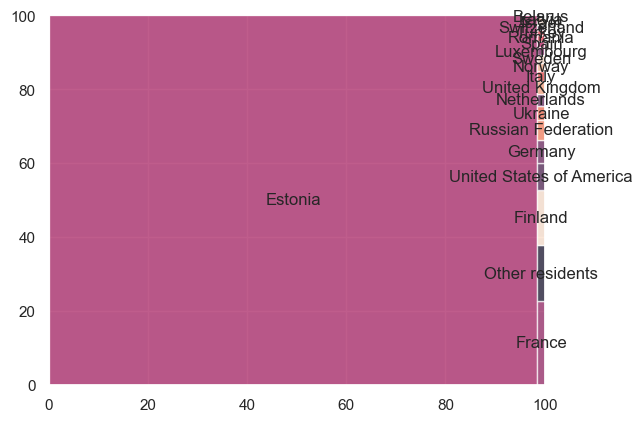

In [60]:
# generate treemap visualization from df_plot dataframe using plt
squarify.plot(
    sizes=df_plot.total_value_eur.tolist(), 
    label=df_plot.country.tolist(), 
    alpha=0.7
)
plt.axis('on')
plt.show()

As can be seen, the value of visualization is not useful, when 1 country takes more than 90% of the whole chart. Let's remove Estonia and try again.

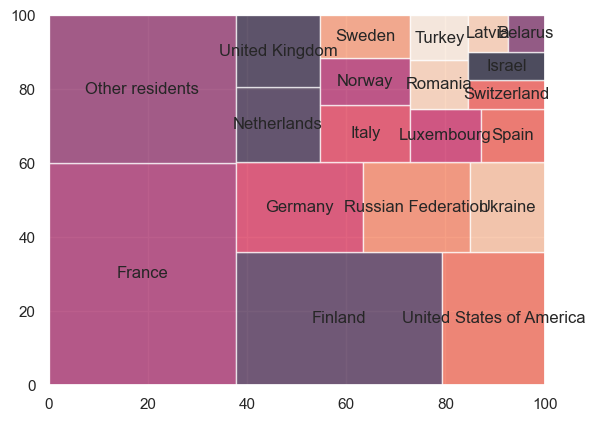

In [61]:
df_plot_wo_est = df_plot[df_plot.country != "Estonia"]
squarify.plot(
    sizes=df_plot_wo_est.total_value_eur.tolist(), 
    label=df_plot_wo_est.country.tolist(), 
    alpha=0.7
)
plt.axis('on')
plt.show()

Since we have the data for 14 years, we can visualize the changes between different years, but also compare counties and compare the nationalities and magnitudes of investments from different countries. Considering that we now remove Estonia, we could also include number of transactions and area to visualization (as dropdown for example).

## Land Use

Here we present a primary analysis of the data. Then, we delve into a more detailed analysis of the types of land-use. In the end, we format the data in order to use for a spider chart showing the different types of land-use.

### Loading and Preprocessing Data

In [62]:
# Load the JSON data
file_path = '../app/public/data/transactions_of_immovables_by_the_purpose_of_use_county_level.json'
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Flatten the JSON data into a DataFrame
rows = []
for county in data:
    county_code = county["MKOOD"]
    for year, records in county["data"].items():
        for record in records:
            if "Total area (ha)" in record and "Total value (eur)" in record:
                rows.append({
                    "County_code": county_code,
                    "Year": int(year),
                    "Land Type": record["Name"],
                    "Number of Transactions": record["Number"],
                    "Total Area (ha)": record["Total area (ha)"],
                    "Total Value (eur)": record["Total value (eur)"],
                })

# Convert to Pandas DataFrame
df = pd.DataFrame(rows)

In [63]:
df.head()

,County_code,Year,Land Type,Number of Transactions,Total Area (ha),Total Value (eur)
0,0037,2010,Residential land,3096,522,211097934
1,0037,2010,Profit yielding land,1042,9582,34264265
2,0037,2010,Other,416,298,25264992
3,0037,2010,Mixed land,174,362,79699305
4,0037,2010,Industrial land,234,179,53721525


In [64]:
# Load the codes-county mapping
county_path = '../app/public/data/id_to_county.json'
with open(county_path, "r", encoding="utf-8") as file:
    county_codes = json.load(file)

# Convert ids to names
df["County_name"] = df["County_code"].map(county_codes)

# Convert "Total Area (ha)" and "Total Value (eur)" to numeric, handling non-numeric values
df["Total Area (ha)"] = pd.to_numeric(df["Total Area (ha)"], errors="coerce")
df["Total Value (eur)"] = pd.to_numeric(df["Total Value (eur)"], errors="coerce")

In [65]:
df.head()

,County_code,Year,Land Type,Number of Transactions,Total Area (ha),Total Value (eur),County_name
0,0037,2010,Residential land,3096,522.0,2.111e+08,Harju maakond
1,0037,2010,Profit yielding land,1042,9582.0,3.426e+07,Harju maakond
2,0037,2010,Other,416,298.0,2.526e+07,Harju maakond
3,0037,2010,Mixed land,174,362.0,7.970e+07,Harju maakond
4,0037,2010,Industrial land,234,179.0,5.372e+07,Harju maakond


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562 entries, 0 to 1561
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   County_code             1562 non-null   object 
 1   Year                    1562 non-null   int64  
 2   Land Type               1562 non-null   object 
 3   Number of Transactions  1562 non-null   int64  
 4   Total Area (ha)         1550 non-null   float64
 5   Total Value (eur)       1550 non-null   float64
 6   County_name             1562 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 85.6+ KB


In [67]:
print(df.isna().sum())
# Drop rows where both area and value are NaN (invalid data)
df.dropna(subset=["Total Area (ha)", "Total Value (eur)"], how="all", inplace=True)
print(df.isna().sum())

County_code                0
Year                       0
Land Type                  0
Number of Transactions     0
Total Area (ha)           12
Total Value (eur)         12
County_name                0
dtype: int64
County_code               0
Year                      0
Land Type                 0
Number of Transactions    0
Total Area (ha)           0
Total Value (eur)         0
County_name               0
dtype: int64


### First Graphs Analysis

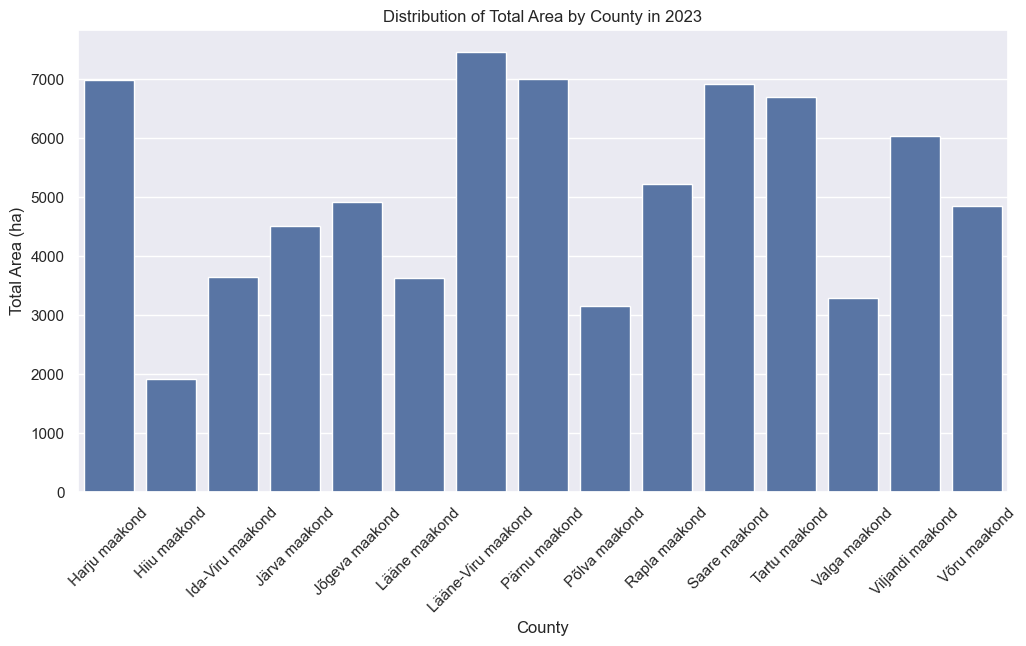

In [68]:
# Select a specific year
year_selected = 2023
df_year = df[df["Year"] == year_selected]
df_year = df_year[df_year["Land Type"] == "TOTAL"]

# Aggregate data by county
df_county = df_year.groupby("County_name").sum(numeric_only=True).reset_index()

# Distribution of total area per county
plt.figure(figsize=(12, 6))
sns.barplot(x=df_county["County_name"], y=df_county["Total Area (ha)"])
plt.xlabel("County")
plt.ylabel("Total Area (ha)")
plt.title(f"Distribution of Total Area by County in {year_selected}")
plt.xticks(rotation=45)
plt.show()


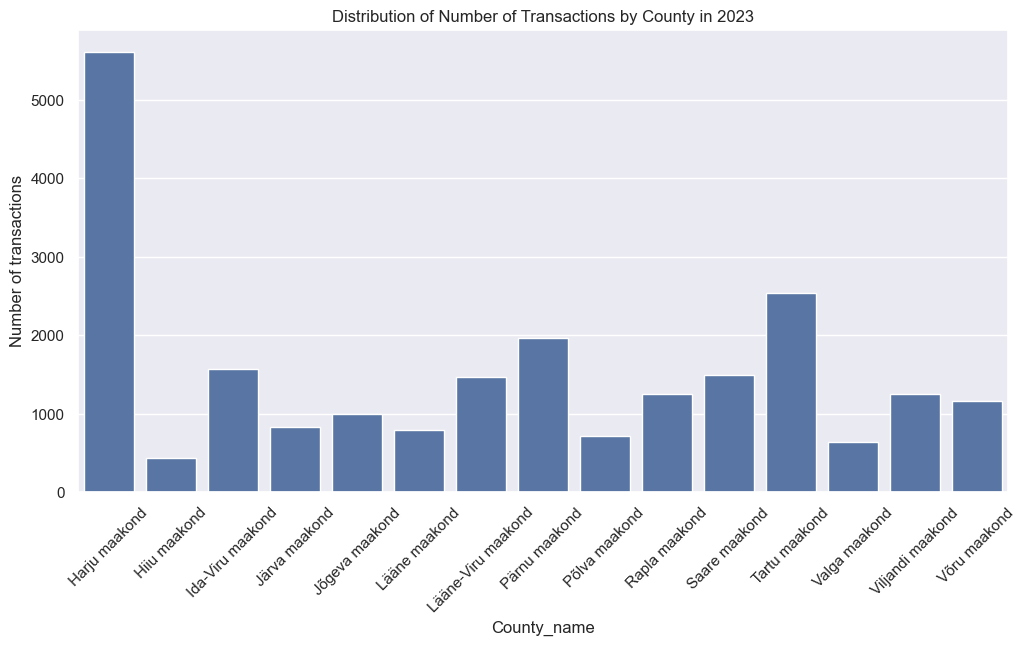

In [69]:
# Select a specific year
year_selected = 2023
df_year = df[df["Year"] == year_selected]
df_year = df_year[df_year["Land Type"] == "TOTAL"]

# Aggregate data by county
df_county = df_year.groupby("County_name").sum(numeric_only=True).reset_index()

# Distribution of total area per county
plt.figure(figsize=(12, 6))
sns.barplot(x=df_county["County_name"], y=df_county["Number of Transactions"])
plt.xlabel("County_name")
plt.ylabel("Number of transactions")
plt.title(f"Distribution of Number of Transactions by County in {year_selected}")
plt.xticks(rotation=45)
plt.show()


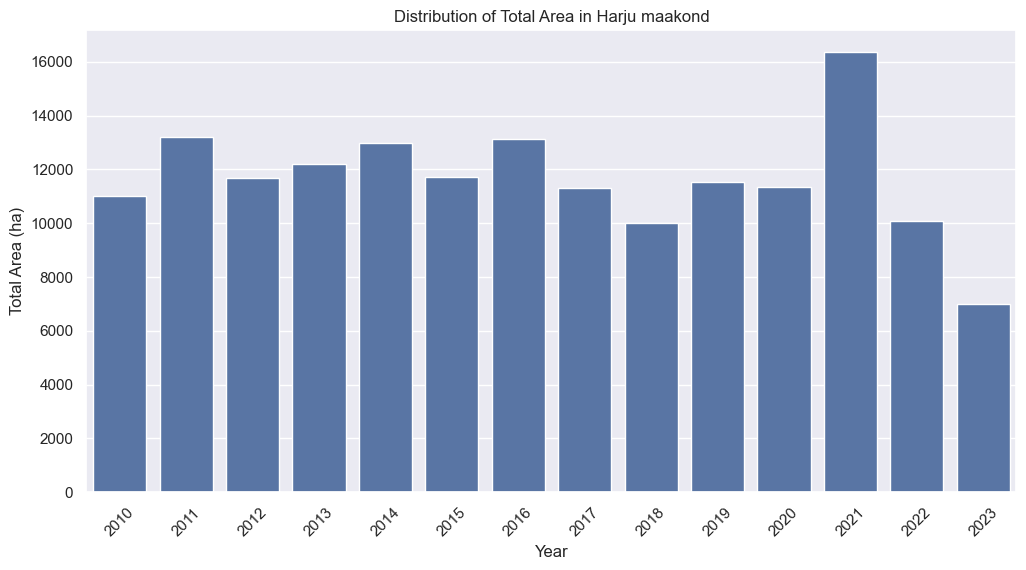

In [70]:
# Select a specific county
county_selected = "Harju maakond"
df_county = df[df["County_name"] == county_selected]
df_county = df_county[df_county["Land Type"] == "TOTAL"]

# Distribution of total area per year
plt.figure(figsize=(12, 6))
sns.barplot(x=df_county["Year"], y=df_county["Total Area (ha)"], legend=False, errorbar=None)
plt.xlabel("Year")
plt.ylabel("Total Area (ha)")
plt.title(f"Distribution of Total Area in {county_selected}")
plt.xticks(rotation=45)
plt.show()

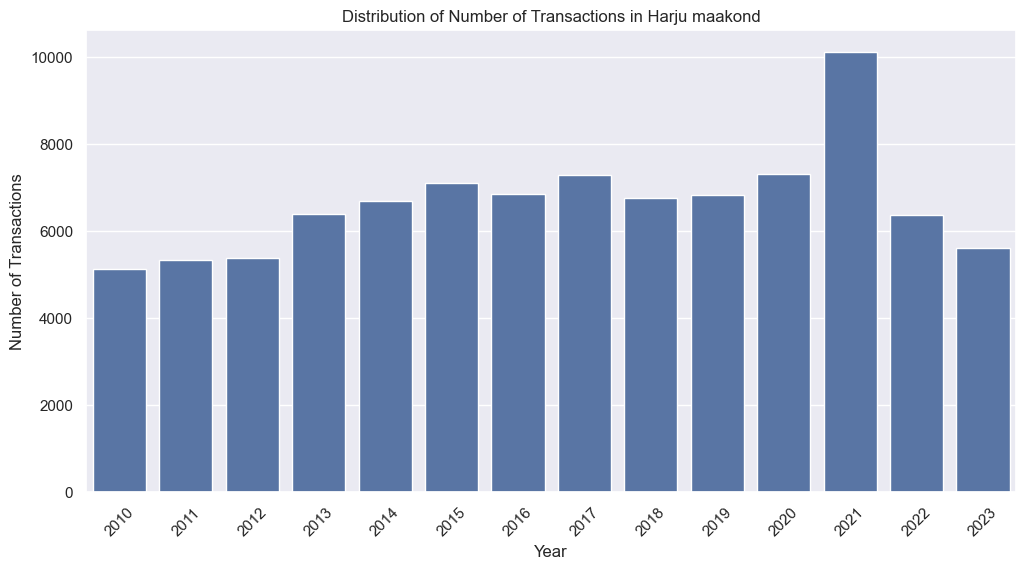

In [71]:
# Select a specific county
county_selected = "Harju maakond"
df_county = df[df["County_name"] == county_selected]
df_county = df_county[df_county["Land Type"] == "TOTAL"]

# Distribution of total area per year
plt.figure(figsize=(12, 6))
sns.barplot(x=df_county["Year"], y=df_county["Number of Transactions"], legend=False, errorbar=None)
plt.xlabel("Year")
plt.ylabel("Number of Transactions")
plt.title(f"Distribution of Number of Transactions in {county_selected}")
plt.xticks(rotation=45)
plt.show()

### Type of lands

In [72]:
print(f"Types of land: {df["Land Type"].unique()}")
# Remove the TOTAL column because it is non of our interet for the spider chart
df_spider = df.drop(df[df["Land Type"] == "TOTAL"].index)
# Keep only interesting columns
df_spider = df_spider[["County_code", "Year", "Land Type", "Total Area (ha)"]].reset_index(drop=True)
df_spider

Types of land: ['Residential land' 'Profit yielding land' 'Other' 'Mixed land'
 'Industrial land' 'Commercial land' 'TOTAL']


,County_code,Year,Land Type,Total Area (ha)
0,0037,2010,Residential land,522.0
1,0037,2010,Profit yielding land,9582.0
2,0037,2010,Other,298.0
3,0037,2010,Mixed land,362.0
4,0037,2010,Industrial land,179.0
...,...,...,...,...
1335,0087,2024,Profit yielding land,5804.0
1336,0087,2024,Other,65.0
1337,0087,2024,Mixed land,143.0
1338,0087,2024,Industrial land,40.0


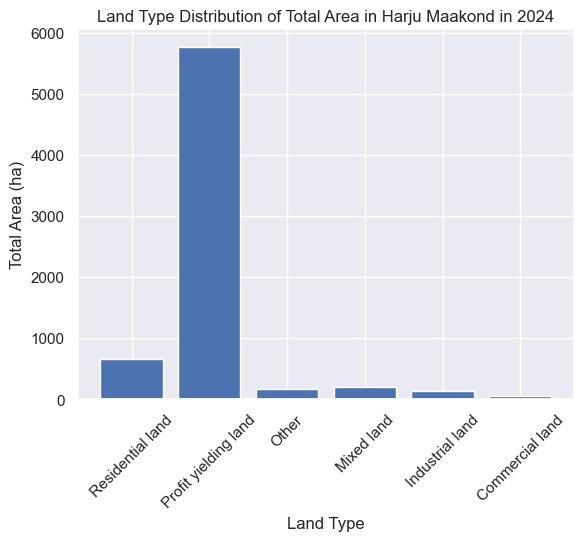

In [73]:
df_spider_county_year = df_spider[(df_spider["County_code"]== "0037") & (df_spider["Year"]== 2023)]

plt.bar(x=df_spider_county_year["Land Type"], height=df_spider_county_year["Total Area (ha)"])
plt.xlabel("Land Type")
plt.ylabel("Total Area (ha)")
plt.title(f"Land Type Distribution of Total Area in Harju Maakond in 2024")
plt.xticks(rotation=45)
plt.show()

### Spider chart formatting

As we can see here, the profit yielding land far exceeds the others. To have comparable values for our spider chart, we normalize the data doing the following:

- Within a year, we take the sum of the total area for each land type
- We divide each value by its corresponding sum, normalizing it within a year

In [74]:
total_area_per_landtype_year = df_spider.groupby(["Year", "Land Type"])["Total Area (ha)"].transform('sum')
df_spider["Normalized Area"] = round(df_spider["Total Area (ha)"] / total_area_per_landtype_year * 100, 2)
df_spider.head()

,County_code,Year,Land Type,Total Area (ha),Normalized Area
0,0037,2010,Residential land,522.0,23.05
1,0037,2010,Profit yielding land,9582.0,8.99
2,0037,2010,Other,298.0,22.03
3,0037,2010,Mixed land,362.0,18.18
4,0037,2010,Industrial land,179.0,18.42


In [75]:
# We export the data in the correct format

json_output = []

# Group by County_code
for county, group in df_spider.groupby("County_code"):
    county_dict = {
        "MKOOD": county,  # Directly using County_code as MKOOD
        "data": {}
    }

    # Group by Year within each County
    for year, year_group in group.groupby("Year"):
        county_dict["data"][str(year)] = [
            {
                "Name": row["Land Type"],
                "Normalized Area": row["Normalized Area"]
            }
            for _, row in year_group.iterrows()
        ]

    json_output.append(county_dict)

with open("normalized_spider_data.json", "w", encoding="utf-8") as f:
    json.dump(json_output, f, indent=4)

## Price Data

### Read Data for Counties
The data has too many levels to be directly read into a dataframe, so we loop over the JSON and extract the relevant information into a df.

In [76]:
with open("../app/public/data/id_to_county.json", encoding="utf-8") as fp:
    id_to_county = json.load(fp,)

with open("../app/public/data/transactions_with_residential_apartments_county_level.json") as fp:
    data = json.load(fp,)

data_tuples = []
# The JSON can't be loaded directly into a dataframe
# For simplicity we just extract the relevant data and put it into a df
for entry in data:
    MKOOD = entry["MKOOD"]
    for year, year_data in entry["data"].items():
        for year_data_area in year_data:
            if year_data_area["Area(m2)"] == "TOTAL":
                data_tuples.append((MKOOD, id_to_county[MKOOD], year, year_data_area['Price per unit area median(eur /m2)']))
            
df_prices = pd.DataFrame(data_tuples, columns=["MKOOD", "county", "year", "median_price"])
df_prices

,MKOOD,county,year,median_price
0,0037,Harju maakond,2010,788.61
1,0037,Harju maakond,2011,871.71
2,0037,Harju maakond,2012,945.15
3,0037,Harju maakond,2013,1100.92
4,0037,Harju maakond,2014,1282.81
...,...,...,...,...
220,0087,Võru maakond,2020,419.03
221,0087,Võru maakond,2021,520.39
222,0087,Võru maakond,2022,617.70
223,0087,Võru maakond,2023,676.82


### Plot counties

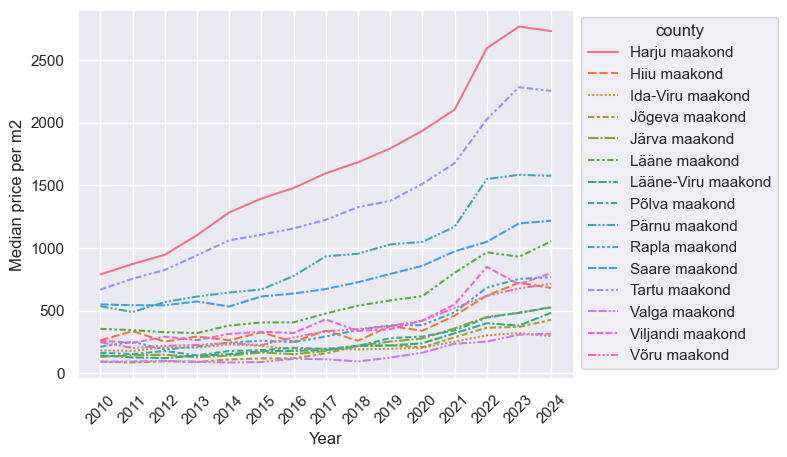

In [77]:
sns.set_theme(style="darkgrid")


# Plot the responses for different events and regions
ax = sns.lineplot(x="year", y="median_price",
             hue="county", style="county",
             data=df_prices)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_xlabel("Year")
ax.set_ylabel("Median price per m2")

ax.tick_params(axis='x', rotation=45)

### Read data for municipalities

In [78]:
with open("../app/public/data/transactions_with_residential_apartments_detailed.json") as fp:
    mun_data = json.load(fp,)

mun_data_tuples = []
# The JSON can't be loaded directly into a dataframe
# For simplicity we just extract the relevant data and put it into a df
for entry in mun_data:
    MKOOD = entry["MKOOD"]
    for year, year_data in entry["data"].items():
        for municipality, mun_year_data in year_data.items():
            for year_data_area in mun_year_data["data"]:
                # Read only the "TOTAL" aggregation of floor areas and only if it's a real value and not the Null equivalent placeholder "***"
                if year_data_area["Area(m2)"] == "TOTAL" and year_data_area['Price per unit area median(eur /m2)'] != "***":
                    mun_data_tuples.append((id_to_county[MKOOD], municipality, year, year_data_area['Price per unit area median(eur /m2)']))
                    
df_prices_mun = pd.DataFrame(mun_data_tuples, columns=["county", "municipality", "year", "median_price"])
df_prices_mun

,county,municipality,year,median_price
0,Harju maakond,Anija vald,2010,190.97
1,Harju maakond,Harku vald,2010,788.83
2,Harju maakond,Jõelähtme vald,2010,591.63
3,Harju maakond,Keila linn,2010,541.42
4,Harju maakond,Kiili vald,2010,662.41
...,...,...,...,...
1121,Võru maakond,Antsla vald,2024,181.94
1122,Võru maakond,Rõuge vald,2024,84.82
1123,Võru maakond,Setomaa vald,2024,400.90
1124,Võru maakond,Võru linn,2024,910.08


### Plot municipalities
Plot the median price per m2 for each municipality. Each plot corresponds to one Estonian county("maakond") and each line on the plot to a specific municipality("vald") within it.

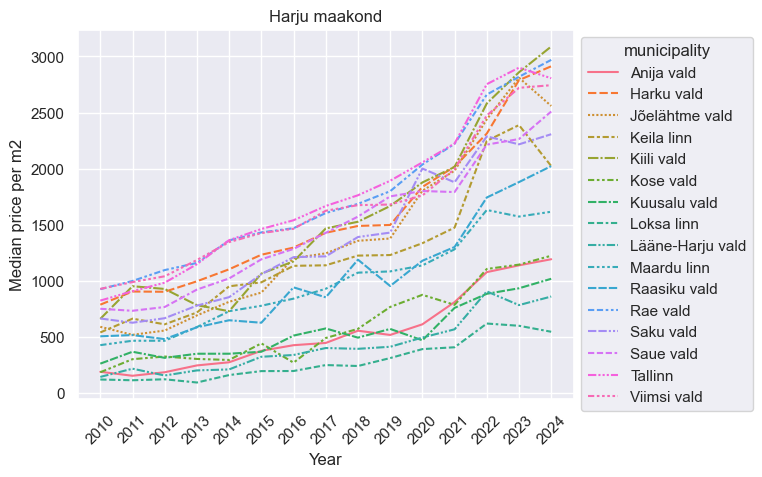

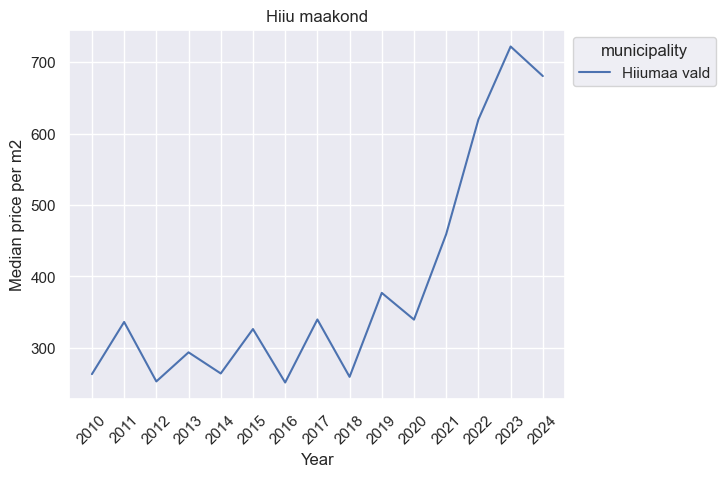

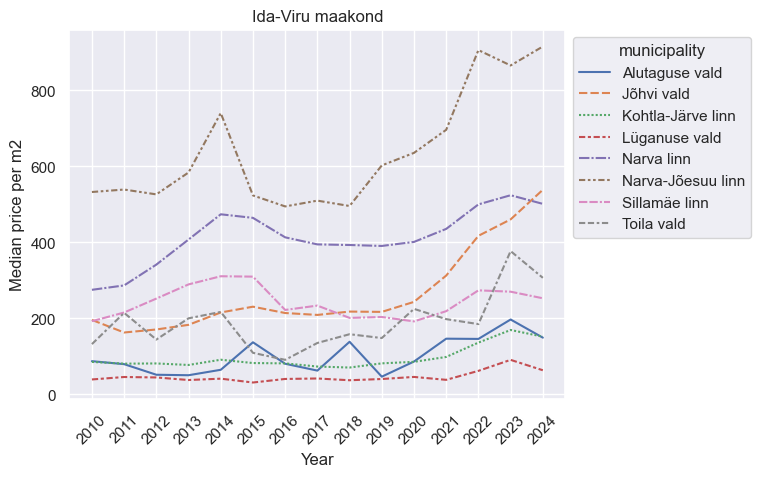

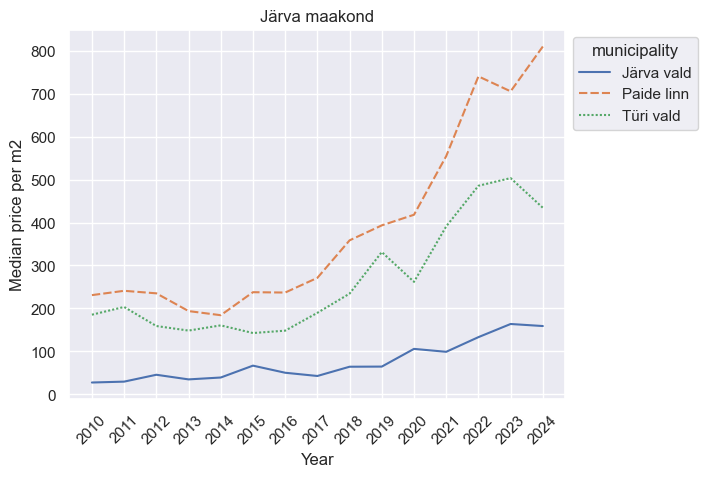

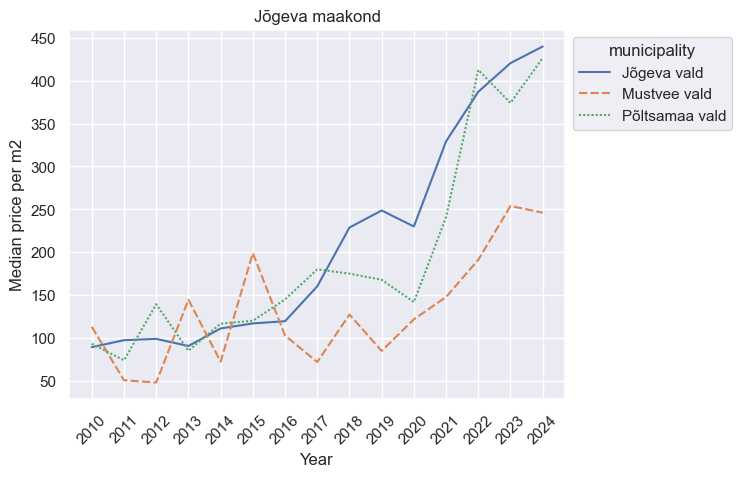

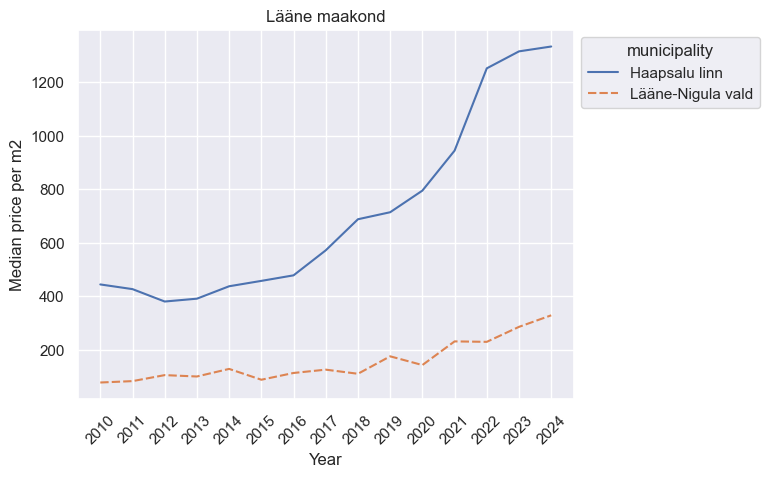

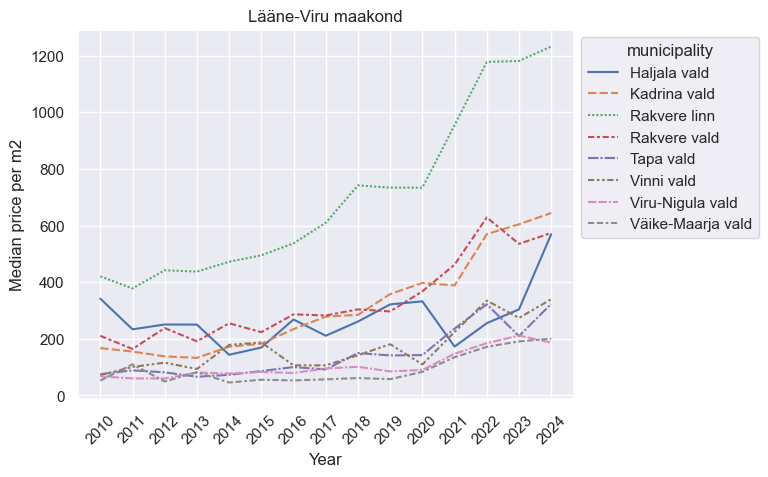

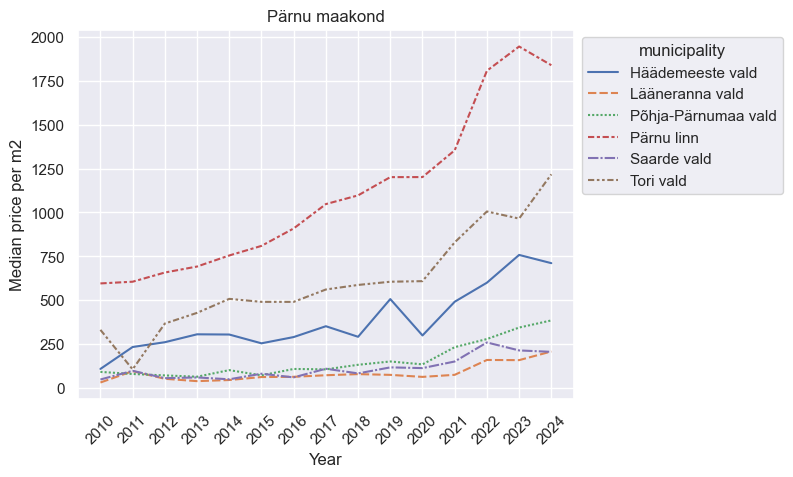

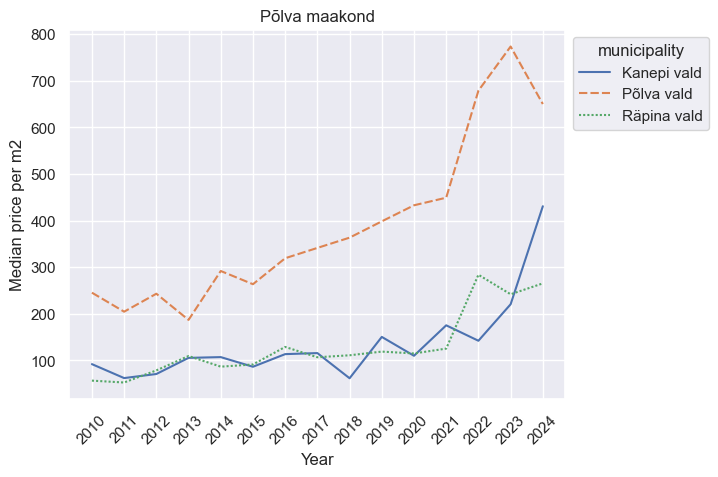

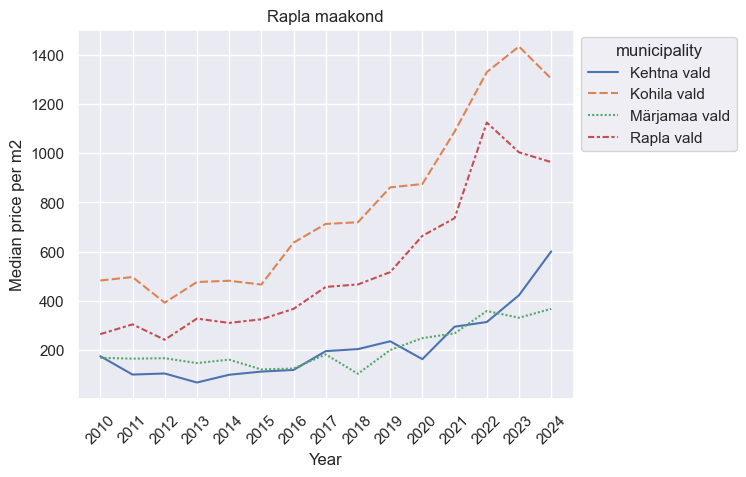

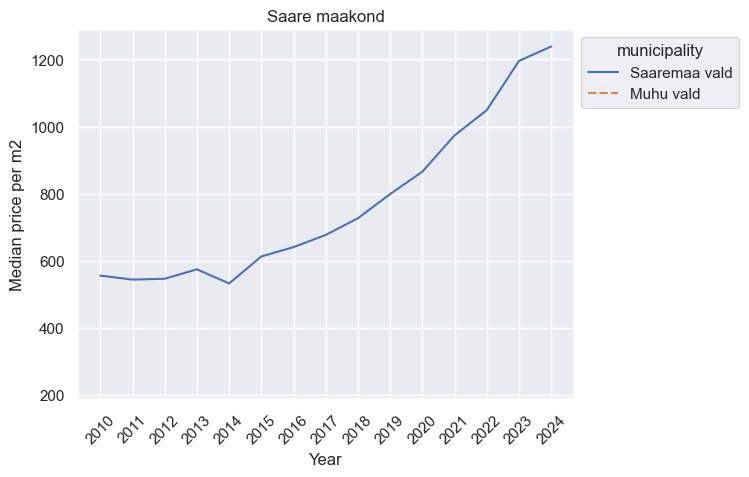

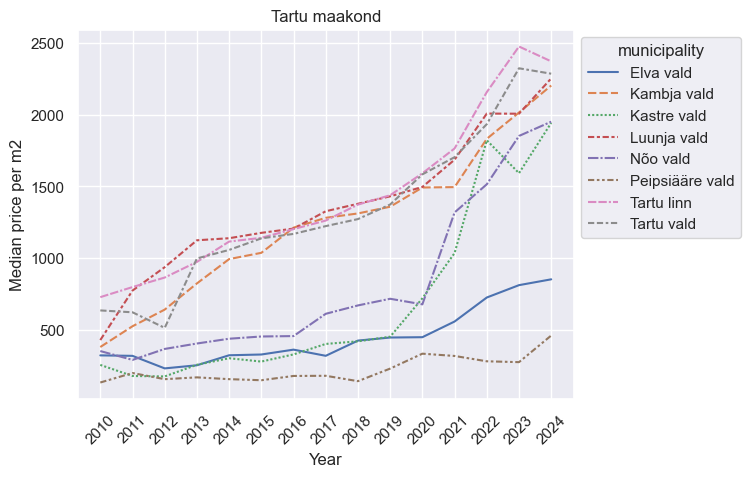

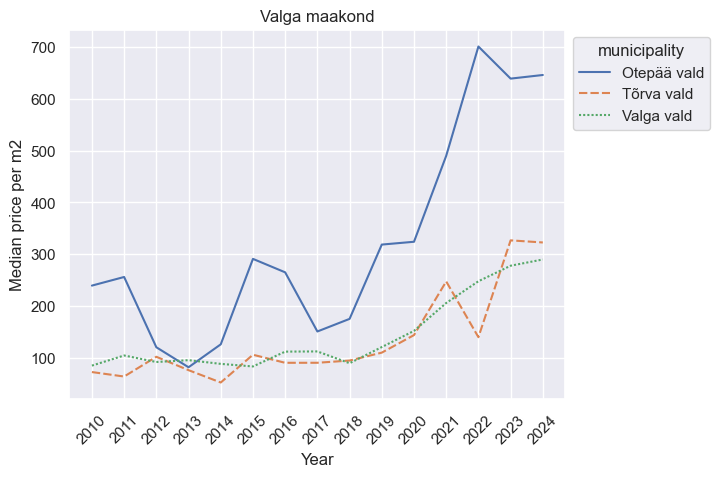

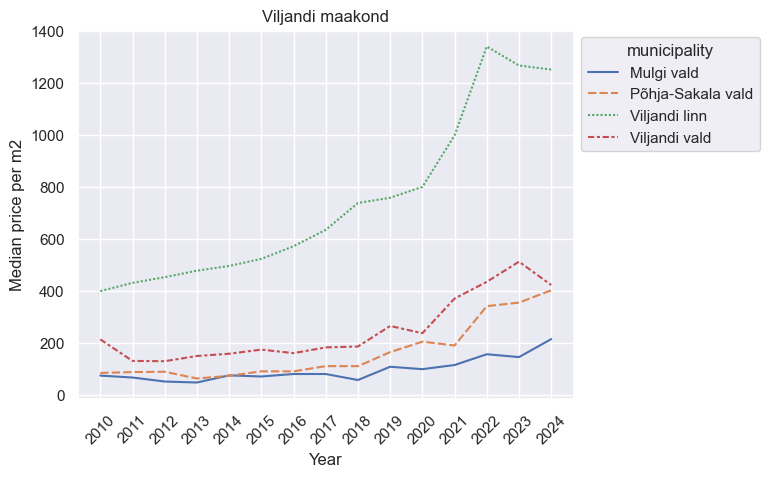

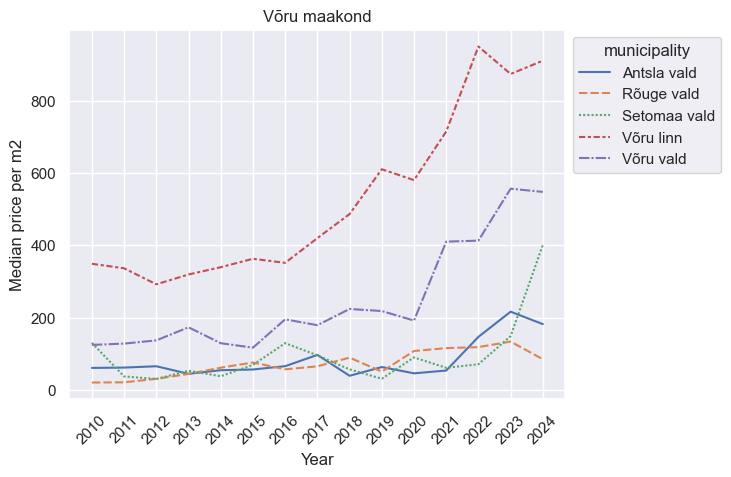

In [79]:
def plot_df(df, label):
    # Filter out rows for relevant municipality
    mun_df = df[df.county == label]
    
    # Create new plot
    plt.figure(label)
    sns.set_theme(style="darkgrid")
    
    # Plot the responses for different events and regions
    ax = sns.lineplot(x="year", y="median_price",
                 hue="municipality", style="municipality",
                 data=mun_df)
    
    # Show legend outside the plot
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    
    ax.set_xlabel("Year")
    ax.set_ylabel("Median price per m2")
    ax.set_title(label)
    
    ax.tick_params(axis='x', rotation=45)
    ax.plot()
    
for municipality in id_to_county.values():
    plot_df(df_prices_mun, municipality)
    